# 1. Introduction and Setup

## 1.1. Problem Overview

This [Kaggle Competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) is a popular time series forecasting challenge.

It is based on Corporación Favorita, a large Ecuadorian-based grocery retailer.

Our goal is to forecast store sales using historical data.

The evaluation metric on the competition is RMSLE (Root Mean Squared Logarithmic Error) - therefore it is the one that we will use for model validation.

## 1.2. Datasets Description

Five different datasets are provided:

- The **training data** will be used is to train the model.
- The **testing data** is for doing predicions to save on the competition.
- The **holidays and events** dataset contains holidays and events, which might affect store sales.
- The **oil** dataset contains the daily oil price, which greatly affects Ecuadorian's economy.
- The **stores** dataset contains information on the company's stores.

## 1.3. Library Imports

First we will import all the libraries we will use.

In [1]:
#Core data libraries
import numpy as np
import pandas as pd

#Visualization and plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Date utilities
from datetime import datetime, timedelta

#Time-series EDA helpers
from learntools.time_series.style import *
from learntools.time_series.utils import plot_lags, plot_periodogram
from statsmodels.graphics.tsaplots import plot_pacf

#Preprocessing and pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Modeling and evaluation
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

#Deterministic time-series basis
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# 2. Load and Explore Data

## 2.1. Load All Datasets

The following code reads all the datasets and saves them as Pandas DataFrames.

In [2]:
#Read data
df_train = pd.read_csv("/kaggle/input/store-sales/train.csv")
df_test = pd.read_csv("/kaggle/input/store-sales/test.csv")
holidays_events = pd.read_csv("/kaggle/input/store-sales/holidays_events.csv")
oil = pd.read_csv("/kaggle/input/store-sales/oil.csv")
stores = pd.read_csv("/kaggle/input/store-sales/stores.csv")

## 2.2. Overview of Each Dataset

### 2.2.1. Training Data

In [3]:
#First rows of training data
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Looking at the description on the Competition we find out what the information in those columns is:

- **id** uniquely identifies each entry by combining date, store and family information.
- **date** is self-explanatory.
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** is self-explanatory.
- **onpromotion** gives the total number of items that were being promoted.

### 2.2.2. Testing Data

In [4]:
#First rows of testing data
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


The testing data has the exact same columns except from **sales**, which is the target we want to predict and submit on the Competition.

### 2.2.3. Holidays and Events

In [5]:
#First rows of holidays and events data
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


- **date** is self-explanatory.
- **type** can take the following values: Holiday, Event, Additional, Transfer, Bridge and Work Day.
- **locale** refers to what locations are affected - National, Regional or Local.
- **locale_name** is the name of the locale affected.
- **description** is self-explanatory.
- **transferred** refers to whether that holiday was moved to another day.

### 2.2.4. Oil

In [6]:
#First rows of oil data
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


The oil DataFrame only has two columns, which are:

- **date** is self-explanatory.
- **dcoilwtico** contains the price of oil in USD.

We notice that we have some dates missing in the **date** column, like 2013-01-05 and 2013-01-06.

### 2.2.5. Stores

In [7]:
#First rows of stores data
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


The columns from stores data are:

- **store_nbr** identifies the store.
- **city** and **state** are self-explanatory.
- **type** identifies which type of store that is - A, B, C, D or E.
- **cluster** is a grouping of similar stores.

## 2.3. Missing Values

### 2.3.1. Inspect Missing Values

In [8]:
#Missing values of each dataset
print("MISSING VALUES")
print("- In training data: {} ".format(df_train.isna().sum().sum()))
print("- In testing data: {} ".format(df_test.isna().sum().sum()))
print("- In holidays and events data: {} ".format(holidays_events.isna().sum().sum()))
print("- In oil data: {} ".format(oil.isna().sum().sum()))
print("- In stores data: {} ".format(stores.isna().sum().sum()))

MISSING VALUES
- In training data: 0 
- In testing data: 0 
- In holidays and events data: 0 
- In oil data: 43 
- In stores data: 0 


It seems we have 43 missing values in the oil dataset.

### 2.3.2. Missing Values in Oil Data

In [9]:
#Missing values in oil data
display(oil.isna().sum())

date           0
dcoilwtico    43
dtype: int64

All the missing values are in the **dcoilwtico** column, which has information on the oil price.

## 2.4. Working with Dates

### 2.4.1. Date Ranges

In [10]:
#Look at date ranges
print("DATE RANGE")
print("- Training data: {} to {}".format(df_train.iloc[0, 1], df_train.iloc[-1, 1]))
print("- Testing data: {} to {}".format(df_test.iloc[0, 1], df_test.iloc[-1, 1]))
print("- Holidays ande events data: {} to {}".format(oil.iloc[0, 0], oil.iloc[-1, 0]))
print("- Oil data: {} to {}".format(holidays_events.iloc[0, 0], holidays_events.iloc[-1, 0]))

DATE RANGE
- Training data: 2013-01-01 to 2017-08-15
- Testing data: 2017-08-16 to 2017-08-31
- Holidays ande events data: 2013-01-01 to 2017-08-31
- Oil data: 2012-03-02 to 2017-12-26


Our forecast origin is 2017-08-15 and we have a 1-step lead time and a 16-step forecast horizon.

The holidays and events, and oil data has information for all the dates we are interested in.

### 2.4.2. Data Types

In [11]:
#Look at datatype of dates
print("DATATYPES")
print("- Training data: {}".format(df_train['date'].dtype))
print("- Testing data: {}".format(df_test['date'].dtype))
print("- Holidays and events data: {}".format(holidays_events['date'].dtype))
print("- Oil data: {}".format(oil['date'].dtype))

DATATYPES
- Training data: object
- Testing data: object
- Holidays and events data: object
- Oil data: object


All the dates are strings instead of timestamps.

### 2.4.3. Date Parsing

The following code parses all the dates, using the correct format.

In [12]:
#Parse dates
df_train['date'] = pd.to_datetime(df_train['date'], format="%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format="%Y-%m-%d")
holidays_events['date'] = pd.to_datetime(holidays_events['date'], format="%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format="%Y-%m-%d")

## 2.5. Time Series Visualization

### 2.5.1. Sampling Strategy

Because we have so many stores and families, we will only plot these four:

- Store and family with highest average sales.
- Store and family with lowest average sales.
- Store and family with most volatibility.
- Random choice of store and family.

The following code gets these stores and families:

In [13]:
#Get highest sales
highest_sales = df_train.groupby(['store_nbr', 'family'])['sales'].mean().idxmax()
highest_sales = list(highest_sales)

#Get lowest sales
lowest_sales = df_train.groupby(['store_nbr', 'family'])['sales'].mean().idxmin()
lowest_sales = list(lowest_sales)

#Get most volatile
most_volatile = df_train.groupby(['store_nbr', 'family'])['sales'].std().idxmax()
most_volatile = list(most_volatile)

#Get random
random_store = np.random.RandomState(seed=0).choice(df_train['store_nbr'].unique(),)
random_family = np.random.RandomState(seed=0).choice(df_train['family'].unique())
random = [random_store, random_family]

### 2.5.2. Plotting Samples

Now, we are ready to make use of visualization tools.

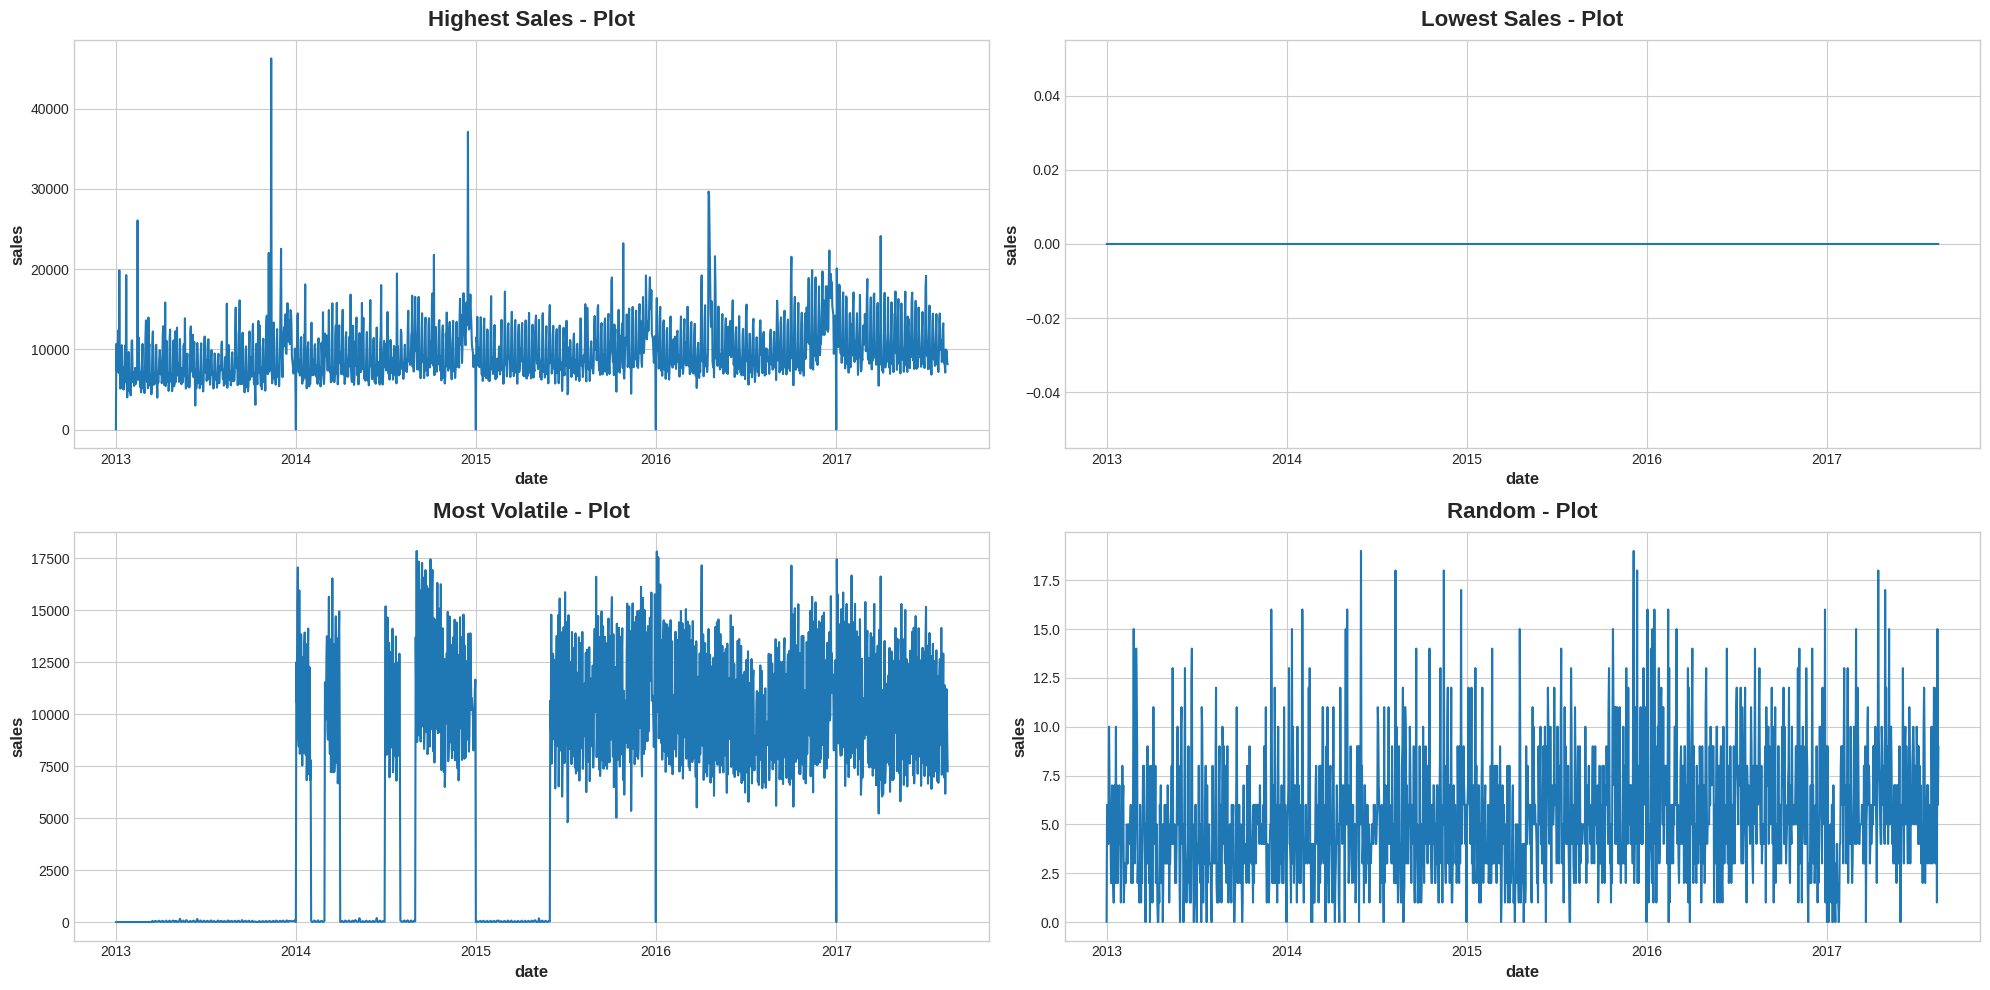

In [14]:
#Plot sales over time
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

df_highest_sales = df_train[(df_train['store_nbr'] == highest_sales[0]) & (df_train['family'] == highest_sales[1])]
sns.lineplot(data=df_highest_sales, x='date', y='sales', ax=axs[0, 0])
axs[0, 0].set_title('Highest Sales - Plot')

df_lowest_sales = df_train[(df_train['store_nbr'] == lowest_sales[0]) & (df_train['family'] == lowest_sales[1])]
sns.lineplot(data=df_lowest_sales, x='date', y='sales', ax=axs[0, 1])
axs[0, 1].set_title('Lowest Sales - Plot')

df_most_volatile = df_train[(df_train['store_nbr'] == most_volatile[0]) & (df_train['family'] == most_volatile[1])]
sns.lineplot(data=df_most_volatile, x='date', y='sales', ax=axs[1, 0])
axs[1, 0].set_title('Most Volatile - Plot')

df_random = df_train[(df_train['store_nbr'] == random[0]) & (df_train['family'] == random[1])]
sns.lineplot(data=df_random, x='date', y='sales', ax=axs[1, 1])
axs[1, 1].set_title('Random - Plot')

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

### 3.1. Missing Dates in Oil Data

We recall from section 2 that some dates are missing in the **date** column of the oil DataFrame.

The following code adds them.

In [15]:
#Add dates that are missing
full_dates = pd.DataFrame({'date': pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')})
oil = full_dates.merge(oil, on='date', how='left')

## 3.2. Useful Dictionaries

Before creating all the features let's define three useful dictionaries:

- **stores_locations** contains the city and state of each store.
- **store_holidays** contains the holidays dates of each store, based in its location.
- **store_attributes** contains the type of cluseter of each store.

In [16]:
#Set indexes
stores = stores.set_index('store_nbr')
holidays_events = holidays_events.set_index('date')
oil = oil.set_index('date')

#Create dictionary with city and state of each store
stores_locations = {}
for num in stores.index:
    stores_locations[num] = [stores.loc[num, 'city'], stores.loc[num, 'state']]

#Drop transferred holidays and events
holidays_events = holidays_events[holidays_events['transferred'] == False]

#Create dictionary holidays dates for each store
store_holidays={}
for num in stores.index:
    store_holidays[num] = []
    for date in holidays_events.index.unique():
        locale_name = holidays_events.loc[date, 'locale_name']
        if isinstance(locale_name, str):
            if locale_name in [stores_locations[num][0], stores_locations[num][1], 'Ecuador']:
                store_holidays[num].append(date)
        else:
            if locale_name.isin([stores_locations[num][0], stores_locations[num][1], 'Ecuador']).any():
                store_holidays[num].append(date)

#Create dictionary type and cluster for each store
store_attributes = {}
for nbr in stores.index:
    store_attributes[nbr] = [stores.loc[nbr, 'type'], stores.loc[nbr, 'cluster']]

## 3.3. Feature Engineering

We will use the following function to create the base features.

These are:

- **is_holiday_event** tells us if there is a holiday or event.
- **store_type** is the store type.
- **store_cluster** is the store cluster.
- **dcoilwtico** is the oil price for that date.

We also multiindex rows by date, store_nbr and family, and drop the id column.

In [17]:
#Assume df has date, store_nbr, onpromotion &  family columns
def preprocess(df):

    #Add column that tells us if there is a holiday or event
    df['is_holiday_event'] = df.apply(lambda row: 1 if row['date'] in store_holidays[row['store_nbr']] else 0, axis=1)

    #Add store type as a feature
    df['store_type'] = df['store_nbr'].map(lambda num: store_attributes[num][0])
    
    #Add store cluster as feature
    df['store_cluster'] = df['store_nbr'].map(lambda num: store_attributes[num][1])

    #Add oil price
    df['dcoilwtico'] = df['date'].map(lambda date: oil['dcoilwtico'].get(date, np.nan))

    #Multiindex dataframe and remove id column
    df = df.set_index(['date', 'store_nbr', 'family'])
    df = df.drop(['id'], axis=1)

    return df

## 3.4. Data Transformation

The following code transforms all the DataFrames using the previous function and defines the sales target, multiindexed too.

In [18]:
#Save test id for competition submission
test_id = df_test['id']

#Get processed DataFrames
df_train = preprocess(df_train)
df_test = preprocess(df_test)

#Define target and drop from training data
y = df_train['sales']
df_train = df_train.drop(['sales'], axis=1)

#Look at first rows of transformed training data
df_train.head()

onpromotion  is_holiday_event store_type  \
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE            0                 1          D   
                     BABY CARE             0                 1          D   
                     BEAUTY                0                 1          D   
                     BEVERAGES             0                 1          D   
                     BOOKS                 0                 1          D   

                                 store_cluster  dcoilwtico  
date       store_nbr family                                 
2013-01-01 1         AUTOMOTIVE             13         NaN  
                     BABY CARE              13         NaN  
                     BEAUTY                 13         NaN  
                     BEVERAGES              13         NaN  
                     BOOKS                  13         NaN

## 3.5. Train and Validation Split

Now we will split the training data in two sets: one will be used for model training and the other one for model validation.

The validation set will contain information for the last 16 days, just like the testing data for the Competition.

In [19]:
#Define split date
split_date = pd.to_datetime("2017-07-31", format="%Y-%m-%d")

#Split training data
X_train = df_train[df_train.index.get_level_values('date') < split_date]
X_valid = df_train[df_train.index.get_level_values('date') >= split_date]

#Split target
y_train = y[y.index.get_level_values('date') < split_date]
y_valid = y[y.index.get_level_values('date') >= split_date]

## 3.6. Preprocessing Pipeline

We will make use of a pipeline to impute missing values in the oil price column and to One Hot encode categorical features.

In [20]:
#Define numerical and categorical columns
numerical_cols = ['onpromotion', 'is_holiday_event', 'dcoilwtico']
categorical_cols = ['store_type', 'store_cluster']

#Define numerical transformer
numerical_transformer = SimpleImputer(strategy='median')

#Define categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

#Fit pipeline on training set
preprocessor.fit(X_train)

#Transform our features for all the datasets
X_train = pd.DataFrame(preprocessor.transform(X_train), columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_valid = pd.DataFrame(preprocessor.transform(X_valid), columns=preprocessor.get_feature_names_out(), index=X_valid.index)
df_train = pd.DataFrame(preprocessor.transform(df_train), columns=preprocessor.get_feature_names_out(), index=df_train.index)
df_test = pd.DataFrame(preprocessor.transform(df_test), columns=preprocessor.get_feature_names_out(), index=df_test.index)

## 3.7. Lag Analysis

### 3.7.1. Lag Plots

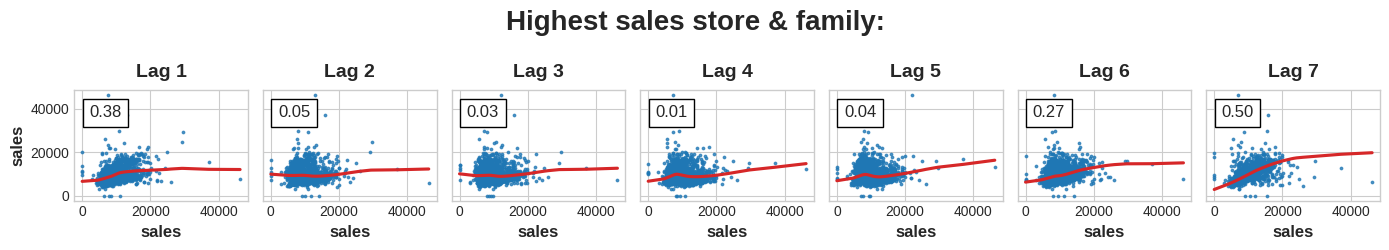

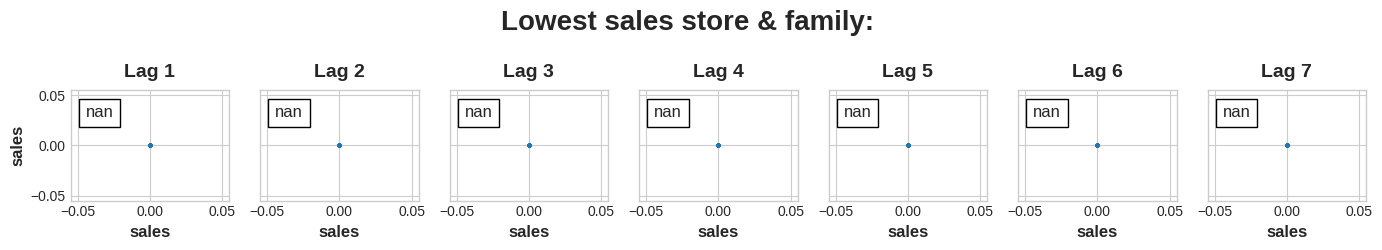

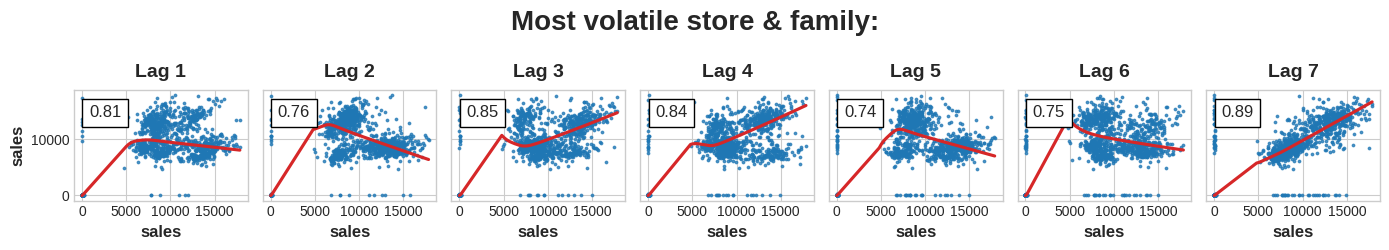

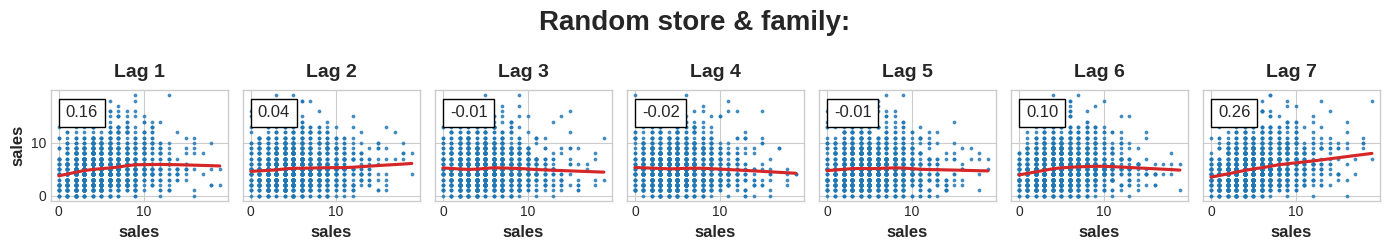

In [21]:
#Lag plot for highest sales store & family
fig = plot_lags(df_highest_sales['sales'], lags=7, nrows=1);
fig.suptitle("Highest sales store & family:", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.99])

#Lag plot for lowest sales store & family
fig = plot_lags(df_lowest_sales['sales'], lags=7, nrows=1);
fig.suptitle("Lowest sales store & family:", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.99])

#Lag plot for most volatile store & family
fig = plot_lags(df_most_volatile['sales'], lags=7, nrows=1);
fig.suptitle("Most volatile store & family:", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.99])

#Lag plot for random store & family
fig = plot_lags(df_random['sales'], lags=7, nrows=1);
fig.suptitle("Random store & family:", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.99])

The highest autocorrelation is seen with a seven-day lag.

Intuitively it makes sense - a good way to predict sales for a given day of the week is to look at the sales of the same day of the week of the previous week.

Except from the most volatile store and family, the relationship between sales and past sales seems to be mostly linear.

### 3.7.2. Partial Autocorrelation

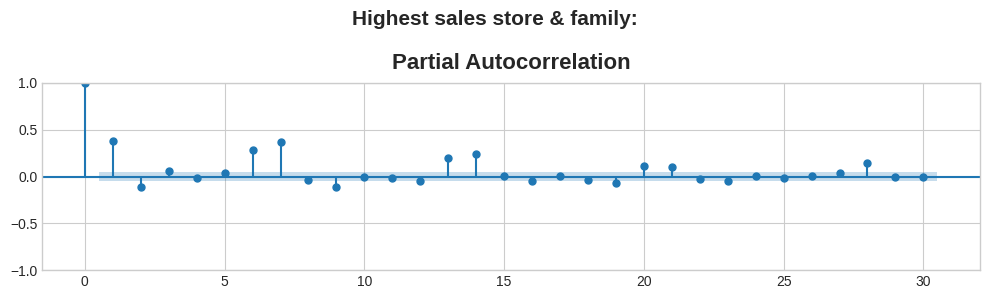

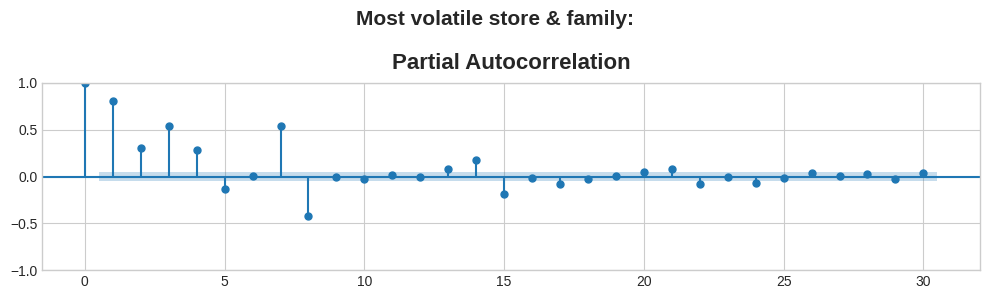

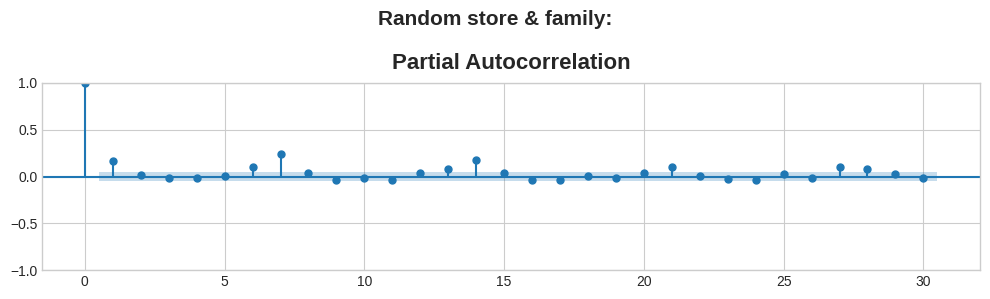

In [22]:
#PACF plot for highest sales store & family
fig = plot_pacf(df_highest_sales['sales'], lags=30);
fig.set_size_inches(10, 3)
fig.suptitle("Highest sales store & family:", fontsize=15)

#PACF plot for most volatile store & family
fig = plot_pacf(df_most_volatile['sales'], lags=30);
fig.set_size_inches(10, 3)
fig.suptitle("Most volatile store & family:", fontsize=15);

#PACF plot for random store & family
fig = plot_pacf(df_random['sales'], lags=30);
fig.set_size_inches(10, 3)
fig.suptitle("Random store & family:", fontsize=15);

The partial autocorrelations tell us the correlation of a lag feature accounting for all the previous lags - the amount of new correlation the lag contributes.

We did not plot for the lowest sales store and family because its sales time series is only zeros.

In general, the highest autocorrelation is seen with multiples of seven.

We also see high autocorrelation on some other lags from 1 to 30 which are not multiples of seven.

For this reason, we will choose lags from 1 to 30 and multiples of seven up to lag 364 (one-year mark).

### 3.7.3. Lag Features

The following function creates the lags we commented in the last section.

It makes use of reindexing and lagged multiindexes - it is very straightforward.

We will use it to create lags for the training set.

In [23]:
def make_lags(df, sales):
    #INPUT:
    #df is DataFrame with base features, multiindexed by ['date', 'store_nbr', 'family'].
    #sales is Series with sales values, multiindexed by ['date', 'store_nbr', 'family'].
    #steps is integer specifying number of time steps for lag features.
    #OUTPUT:
    #Returns df with added lagged features..

    df_copy = df.copy()
    
    dates = df_copy.index.get_level_values('date').unique()
    lags = [i for i in range(1, 31)] + [7*i for i in range(5, 53)]
    
    for num in lags:

        #Extract index levels
        dates = df_copy.index.get_level_values('date')
        stores = df_copy.index.get_level_values('store_nbr')
        families = df_copy.index.get_level_values('family')
        
        #Create a MultiIndex matching sales dates for lag feature
        lagged_dates = dates - pd.Timedelta(days=num)
        
        lagged_index = pd.MultiIndex.from_arrays(
            [lagged_dates, stores, families],
            names=['date', 'store_nbr', 'family']
        )
        
        #Reindex sales to get lagged values aligned with df index
        lagged_values = sales.reindex(lagged_index).fillna(0).values

        df_copy[f"lag_{num}"] = lagged_values
    
    return df_copy

#Create lag features for training set
X_train = make_lags(X_train, y_train)

# 4. Modeling and Evaluation

## 4.1. Evaluation Metric

Let's define our evaluation metric, RMSLE.

In [24]:
#Define RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

#Define evaluation metric for fitting model
def rmsle_eval(preds, dtrain):
    y_true = dtrain.get_label()
    preds = np.clip(preds, 0, None)
    rmsle = np.sqrt(np.mean((np.log1p(y_true) - np.log1p(preds)) ** 2))
    return 'rmsle', rmsle

## 4.2. Model Training

We will use an XGB model to predict sales for a given combination of date, store_nbr and family, based on all the base features for that combination and the lag features.

In order to use early stopping rounds, we will create a copy of the validation set with added lag features.

In [25]:
#Define model
xgb = XGBRegressor(n_estimators=1000, early_stopping_rounds=10, random_state=0)

#Create copy of validation set with added lag features
X_valid_lags = make_lags(X_valid, y)

#Fit XGB model
xgb.fit(X_train, y_train, eval_set=[(X_valid_lags, y_valid)], eval_metric=rmsle_eval, verbose=False);

## 4.3. Recursive Forecasting

Because we have a 16-step forecast horizon and our model can only predict one step at a time, we will use a recursive strategy.

In each step, we will use the forecasts to update the lag features for the next step.

The following function does that.

In [26]:
def make_predictions(model, df, sales):
    #INPUT:
    #df is data frame with base features.
    #sales is series with sales info up to the first date of df.

    #OUTPUT:
    #returns series with predictions for the dates of df using recursive strategy.

    prediction_dates = df.index.get_level_values('date').unique()
    
    for date in prediction_dates:
        features = df[df.index.get_level_values('date') == date]
        features = make_lags(features, sales)
        preds = pd.Series(model.predict(features), index=features.index)
        sales = sales.combine_first(preds)

    return sales.loc[sales.index.get_level_values('date').isin(prediction_dates)]

## 4.4. Model Validation

Let's use the previous function to make predictions on the validation set and evaluate performance.

Since RMSLE cannot evaluate negative values, we will get rid of those and replace them with zero.

In [27]:
#Get predictions for validation set and get rid of negative values
valid_preds = make_predictions(xgb, X_valid, y_train)
valid_preds[valid_preds<0] = 0

#Look at score
rmsle(y_valid, valid_preds)

1.1639633296208243

## 4.5. Predictions Visualization

Let's make use of visualization tools to see how our model predicted sales.

We will plot the sales in 2017 of the four stores and families we chose in section 2 and add our predictions in orange.

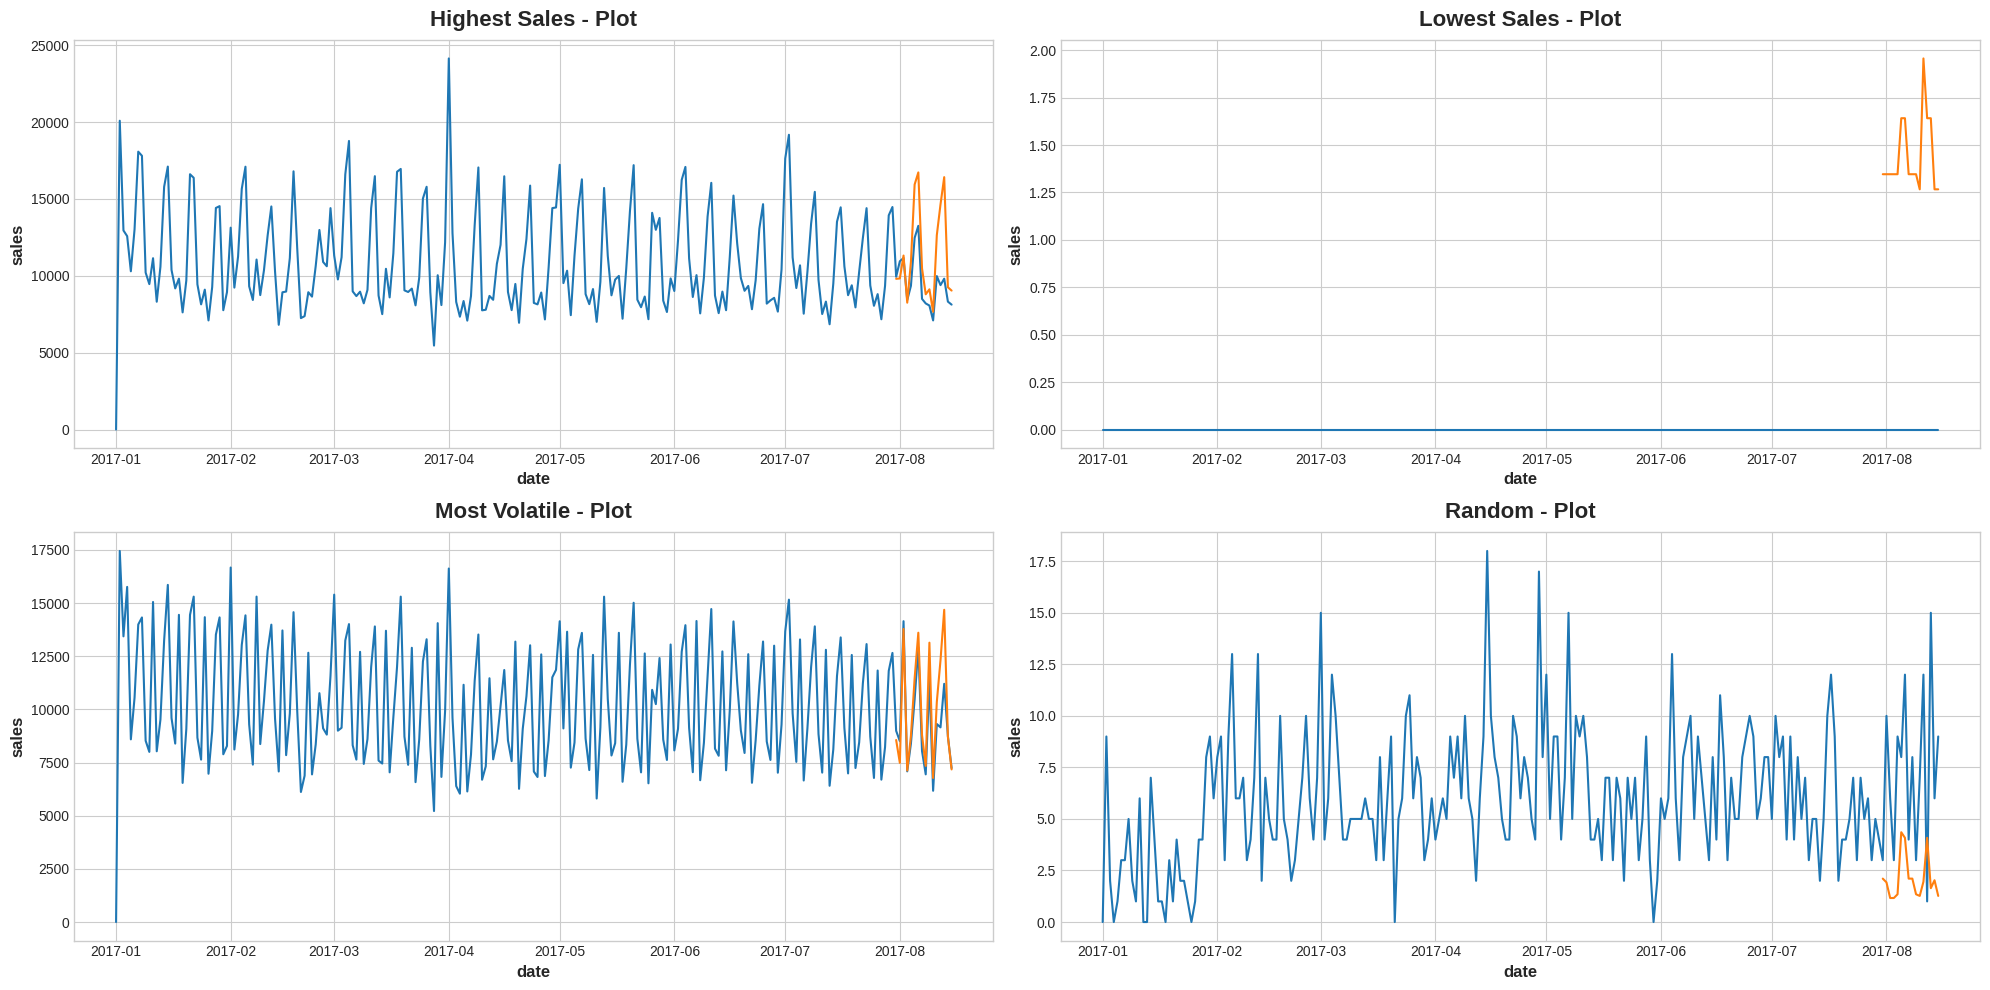

In [28]:
#Plot real sales compared with predictions
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(data=df_highest_sales[df_highest_sales['date'].dt.year == 2017], x='date', y='sales', ax=axs[0, 0])
highest_sales_preds = valid_preds[(valid_preds.index.get_level_values('date').year == 2017)
                        & (valid_preds.index.get_level_values('store_nbr') == highest_sales[0])
                        & (valid_preds.index.get_level_values('family') == highest_sales[1])]
sns.lineplot(
    x=highest_sales_preds.index.get_level_values('date'),
    y=highest_sales_preds.values, ax=axs[0, 0])
axs[0, 0].set_title('Highest Sales - Plot')

sns.lineplot(data=df_lowest_sales[df_lowest_sales['date'].dt.year == 2017], x='date', y='sales', ax=axs[0, 1])
lowest_sales_preds = valid_preds[(valid_preds.index.get_level_values('date').year == 2017)
                        & (valid_preds.index.get_level_values('store_nbr') == lowest_sales[0])
                        & (valid_preds.index.get_level_values('family') == lowest_sales[1])]
sns.lineplot(
    x=lowest_sales_preds.index.get_level_values('date'),
    y=lowest_sales_preds.values, ax=axs[0, 1])
axs[0, 1].set_title('Lowest Sales - Plot')

sns.lineplot(data=df_most_volatile[df_most_volatile['date'].dt.year == 2017], x='date', y='sales', ax=axs[1, 0])
most_volatile_preds = valid_preds[(valid_preds.index.get_level_values('date').year == 2017)
                        & (valid_preds.index.get_level_values('store_nbr') == most_volatile[0])
                        & (valid_preds.index.get_level_values('family') == most_volatile[1])]
sns.lineplot(
    x=most_volatile_preds.index.get_level_values('date'),
    y=most_volatile_preds.values, ax=axs[1, 0])
axs[1, 0].set_title('Most Volatile - Plot')

sns.lineplot(data=df_random[df_random['date'].dt.year == 2017], x='date', y='sales', ax=axs[1, 1])
random_preds = valid_preds[(valid_preds.index.get_level_values('date').year == 2017)
                        & (valid_preds.index.get_level_values('store_nbr') == random[0])
                        & (valid_preds.index.get_level_values('family') == random[1])]
sns.lineplot(
    x=random_preds.index.get_level_values('date'),
    y=random_preds.values, ax=axs[1, 1])
axs[1, 1].set_title('Random - Plot')

plt.tight_layout()
plt.show()

## 4.6. Feature Importance

Let's see which are the features the model considered most important.

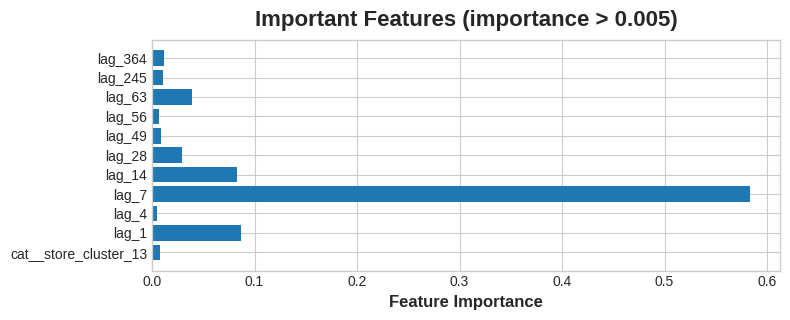

In [29]:
#Get features and feature importances
features = list(X_train.columns)
importances = list(xgb.feature_importances_)

# Create a list of (feature, importance) and filter
filtered = [(f, i) for f, i in zip(features, importances) if i > 0.005]

# Unzip back to two lists
filtered_features, filtered_importances = zip(*filtered)

# Plot
plt.figure(figsize=(8, len(filtered_features) * 0.3))  # optional: adjust height dynamically
plt.barh(y=filtered_features, width=filtered_importances)
plt.xlabel("Feature Importance")
plt.title("Important Features (importance > 0.005)")
plt.show()

# 5. Trend and Seasonality Model

## 5.1. Seasonal Component

Let's now build a model by combining the trend and seasonal components.

Since our XGB model didn't consider external features very important, we will only use the sales time series for this model - completely ignoring all external features.

Let's first plot a periodogram and look for periodicity in our sales time-series.

We will use the random store & family combination.

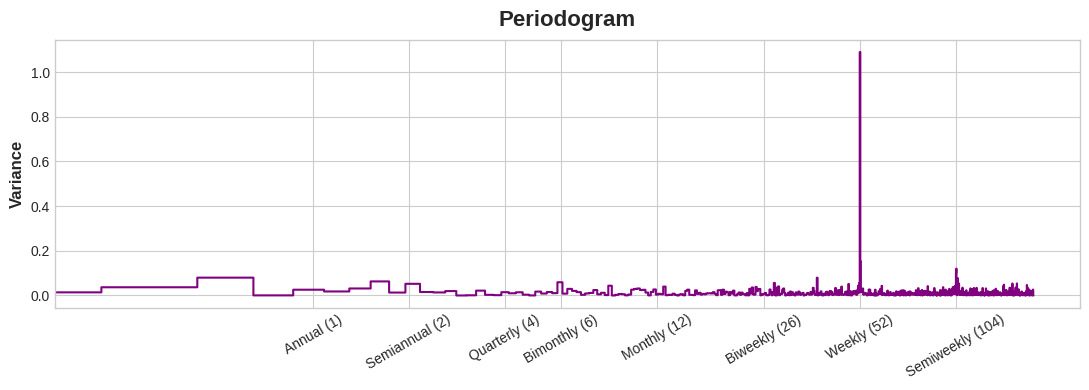

In [30]:
#Plot periodogram
plot_periodogram(df_random['sales']);

## 5.2. Trend and Seasonality Features

In the last section we noticed a high weekly periodicity.

Let's now create our trend and seasonality features.

We will use both day-of-week encoded features and Fourier features to model seasonability.

The trend component will be modeled with a first-order polynomial.

In [31]:
#Fourier features
fourier = CalendarFourier(freq='M', order=4)

#Deterministic process
dp = DeterministicProcess(
    index=y.index.get_level_values('date').unique().to_period('D'),
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

#Create features
features = dp.in_sample()
features_test = dp.out_of_sample(steps=16)

#Split into training and validation
features_train = features[features.index.to_timestamp() < split_date]
features_valid = features[features.index.to_timestamp() >= split_date]

#Look at first rows
features.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


## 5.3. Target Definition

The following code defines our sales target, now multiindexed by columns.

In [32]:
#Define target multiindexed in columns
target = y.reset_index().pivot_table(index='date', values='sales', columns=['store_nbr', 'family'])

#Split into training and validation
target_train = target[target.index < split_date]
target_valid = target[target.index >= split_date]

#Look at first rows of target
target.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

## 5.4. Model Training

Let's now fit a Linear Regression model, which works very well with multi-output targets.

In [33]:
#Define model
linear_regression = LinearRegression(fit_intercept=False)

#Fit model
linear_regression.fit(features_train, target_train);

## 5.5. Model Validation

In [34]:
#Make predictions and get rid of negative values
valid_preds = valid_preds = pd.DataFrame(
    linear_regression.predict(features_valid),
    index=features_valid.index,
    columns=target_train.columns
)
valid_preds[valid_preds<0] = 0

#Look at RMSLE score
rmsle(target_valid, valid_preds)

0.6001040622922278

We notice a big improvement from our recursive machine learning model.

## 5.5. Predictions Visualization

Let's use visualization tools to see how well our model made predictions, just like before.

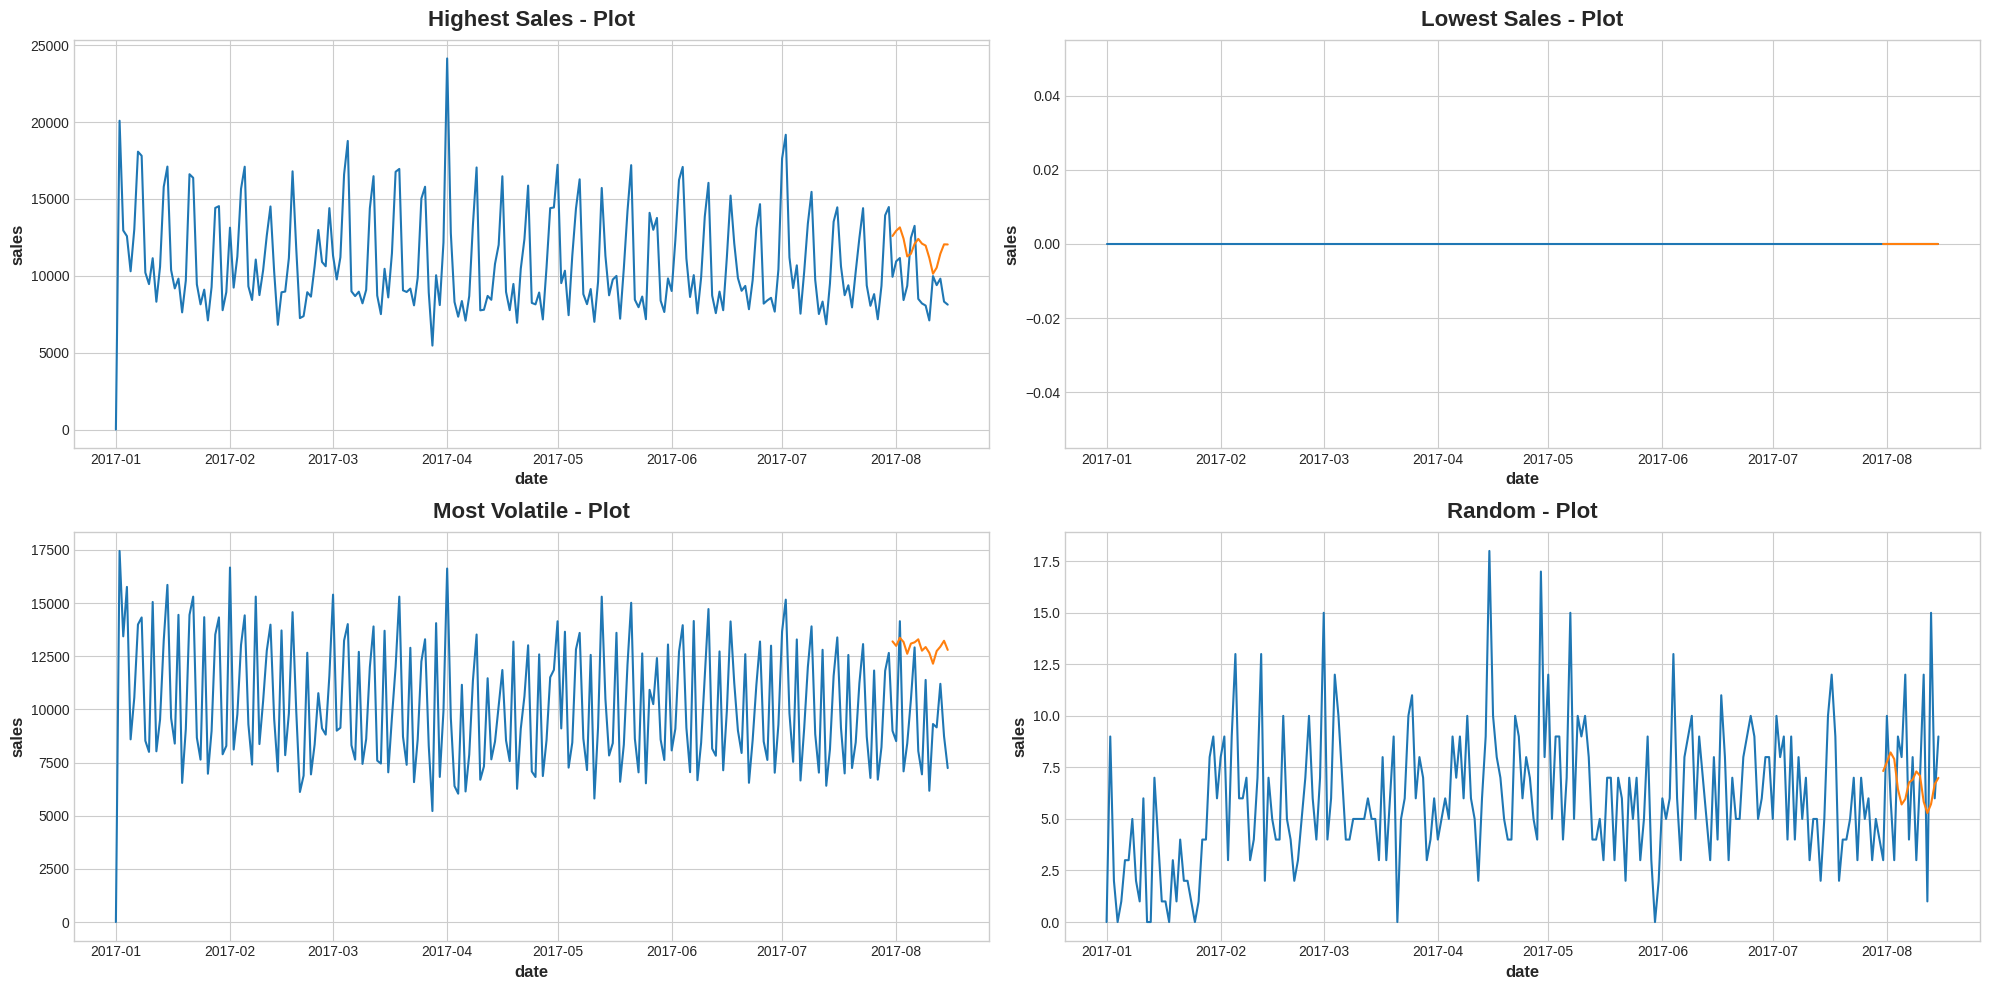

In [35]:
#Plot real sales compared with predictions
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(data=df_highest_sales[df_highest_sales['date'].dt.year == 2017], x='date', y='sales', ax=axs[0, 0])
highest_sales_preds = valid_preds.loc[
    valid_preds.index.year == 2017,
    (highest_sales[0], highest_sales[1])
]
sns.lineplot(
    x=highest_sales_preds.index.get_level_values('date'),
    y=highest_sales_preds.values, ax=axs[0, 0])
axs[0, 0].set_title('Highest Sales - Plot')

sns.lineplot(data=df_lowest_sales[df_lowest_sales['date'].dt.year == 2017], x='date', y='sales', ax=axs[0, 1])
lowest_sales_preds = valid_preds.loc[
    valid_preds.index.year == 2017,
    (lowest_sales[0], lowest_sales[1])
]
sns.lineplot(
    x=lowest_sales_preds.index.get_level_values('date'),
    y=lowest_sales_preds.values, ax=axs[0, 1])
axs[0, 1].set_title('Lowest Sales - Plot')

sns.lineplot(data=df_most_volatile[df_most_volatile['date'].dt.year == 2017], x='date', y='sales', ax=axs[1, 0])
most_volatile_preds = valid_preds.loc[
    valid_preds.index.year == 2017,
    (most_volatile[0], most_volatile[1])
]
sns.lineplot(
    x=most_volatile_preds.index.get_level_values('date'),
    y=most_volatile_preds.values, ax=axs[1, 0])
axs[1, 0].set_title('Most Volatile - Plot')

sns.lineplot(data=df_random[df_random['date'].dt.year == 2017], x='date', y='sales', ax=axs[1, 1])
random_preds = valid_preds.loc[
    valid_preds.index.year == 2017,
    (random[0], random[1])
]
sns.lineplot(
    x=random_preds.index.get_level_values('date'),
    y=random_preds.values, ax=axs[1, 1])
axs[1, 1].set_title('Random - Plot')

plt.tight_layout()
plt.show()

# 6. Final Forecast and Submission

## 6.1. Full Data Training

The trend and seasonality model will be used because it achieved the lowest RMSLE in the validation set.

Let's fit it in the full training data.

In [36]:
#Fit linear regression model on full training data
linear_regression.fit(features, target);

## 6.2. Make Predictions and Submit

The following code makes a prediction in the test data and creates a submission file for the competition.

In [37]:
#Get predictions for test and get rid of negative values
test_preds = pd.DataFrame(linear_regression.predict(features_test),
                          index=features_test.index,
                          columns=target.columns)
test_preds[test_preds<0] = 0

#Submit to competition
output = pd.DataFrame({'id': test_id, 'sales': test_preds.stack(['store_nbr', 'family']).values})
output.to_csv('submission.csv', index=False)

## 6.3. Conclusions & Learnings

Our initial XGB model considered the lag features to be most important, especially multiples of seven.

Since most external features were ignored, we decided to create a model to fit trend and seasonality - completely ignoring all external features.

Surprisingly, it performed much better than the initial model.

The final model could definitely be improved by further feature engineering.

All in all, I am very happy with my first time-series forecasting project and I learnt a lot.

Thanks for reading!